In [1]:
# Import the necessary libraries
import pygame
import serial
import numpy as np
import csv
import math
from scipy.integrate import cumulative_trapezoid
import time
import pandas as pd

pygame 2.6.1 (SDL 2.28.4, Python 3.12.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:

class DigitalTwin:
    def __init__(self):
        # Initialize Pygame parameters
        self.screen = None

        # Initialize serial communication parameters
        self.ser = None
        self.device_connected = False

###

        self.x_pivot_limit = 100
        self.integral_error = 0.0

###

        # State configuration parameters
        self.steps = 0
        self.theta = 0.     #np.pi-0.01
        self.theta_dot = 0.
        self.theta_double_dot = 0.
        self.x_pivot = 0
        self.delta_t = 0.005  # Example value, adjust as needed in seconds
        self.j_fric = 0.3

        # Model parameters
        self.m = 1         # Mass of the pendulum (kg)
        self.g = 9.8065     # Acceleration due to gravity (m/s^2)
        self.l = 0.8       # Length of the pendulum (m)
        self.c_air = 0.02    # Air friction coefficient
        self.c_c = 0.1      # Coulomb friction coefficient
        self.a_m = 2000     # Motor acceleration force tranfer coefficient
        self.future_motor_accelerations = []
        self.future_motor_positions = []
        self.currentmotor_acceleration = 0.
        self.time = 0.
        
        # Sensor data
        self.sensor_theta = 0
        self.current_sensor_motor_position = 0.
        self.current_action = 0
        
        # Keyboard action mappings
        _action_durations = [200, 150, 100, 50]  # Durations in milliseconds
        _keys_left = [pygame.K_a, pygame.K_s, pygame.K_d, pygame.K_f]
        _keys_right = [pygame.K_SEMICOLON, pygame.K_l, pygame.K_k , pygame.K_j]
        self.actions = {key: ('left', duration) for key, duration in zip(_keys_left, _action_durations)}
        self.actions.update({key: ('right', duration) for key, duration in zip(_keys_right, _action_durations)})
        self.action_map = [
            ('left', 0),  # No action
            ('left', 50), ('left', 100), ('left', 150), ('left', 200),
            ('right', 50), ('right', 100), ('right', 150), ('right', 200)
        ]
        self.recording = False
        self.writer = None
        self.start_time = 0.
        self.df = None
        
        # Initialize a pygame window
        self.initialize_pygame_window()

    def initialize_pygame_window(self):
        # Set up the drawing window
        pygame.init()
        self.screen = pygame.display.set_mode([1000, 800])

    def connect_device(self, port='COM3', baudrate=115200):
        # Establish a serial connection for sensor data
        self.ser = serial.Serial(port=port, baudrate=baudrate, timeout=0, writeTimeout=0)
        self.device_connected = True
        print("Connected to: " + self.ser.portstr)

    def read_data(self):
        line = self.ser.readline()
        line = line.decode("utf-8")
        try:
            if len(line) > 2 and line != '-':
                sensor_data = line.split(",")
                if len(sensor_data[0]) > 0 and len(sensor_data[3]) > 0:
                    self.sensor_theta = int(sensor_data[0])
                    self.current_sensor_motor_position = -int(sensor_data[3])
        except Exception as e:
            print(e)
        if self.recording:
            self.writer.writerow([round(time.time() * 1000)-self.start_time, self.sensor_theta, self.current_sensor_motor_position])

    def process_data(self):
        """
        Lab 2: Use the sensor data retured by the function read_data. 
        The sensor data needs to be represented in the virtual model.
        First the data should be scaled and calibrated,
        Secondly noise should be reduced trough a filtering method.
        Return the processed data such that it can be used in visualization and recording.
        Also, transform the current_sensor_motor_position to be acurate. 
        This means that the encoder value should be scaled to match the displacement in the virtual model.
        """
        self.sensor_theta = 0
        self.current_sensor_motor_position = 0
        
    def start_recording(self, name):
        # If you are working on the bonus assignments then you should also add a columb for actions (and safe those).
        self.recording = True
        self.file = open('{}.csv'.format(name), 'w', newline='')  
        self.writer = csv.writer(self.file)
        self.start_time = round(time.time() * 1000)
        self.writer.writerow(["time", "theta", "x_pivot"])

    def stop_recording(self):
        self.recording = False
        self.file.close()
    
    def load_recording(self, name):
        self.df = pd.read_csv('{}.csv'.format(name))
        print("recording is loaded")
    
    def recorded_step(self,i):
        a = self.df["time"].pop(i)
        b = self.df["theta"].pop(i)
        c = self.df["x_pivot"].pop(i)  
        return a, b, c

    def perform_action(self, direction, duration):
        # Send the command to the device.
        if self.device_connected:
            if direction == 'left':
                d = -duration
            else:
                d = duration
            self.ser.write(str(d).encode())
        if duration > 0:
            self.update_motor_accelerations(direction, duration/1000)

    def update_motor_accelerations(self, direction, duration):
        if direction == 'left':
            direction = -1
        else:
            direction = 1

        """
        Lab 1 & 3 bonus: Model the expected acceleration response of the motor.  
        """
        a_m_1 = 0.05
        a_m_2 = 0.05
        t1 = duration/4
        t2_d = duration/4
        t2 = duration - t2_d
        for t in np.arange(0.0, duration + self.delta_t, self.delta_t):
            if t <= t1:
                c = -4 * direction * a_m_1/(t1 * t1) * t * (t-t1)
            elif t < t2 and t > t1:
                c = 0 
            elif t >= t2:
                c = 4 * direction * a_m_2 /(t2_d * t2_d) * (t-t2) * (t-duration)
            
            self.future_motor_accelerations.append(c)
        
        _velocity = cumulative_trapezoid(self.future_motor_accelerations,initial=0)
        self.future_motor_positions = list(cumulative_trapezoid(_velocity,initial=0))
        
    def get_theta_double_dot(self, theta, theta_dot):
        """
        Lab 1: Model the angular acceleration (theta_double_dot) 
        as a function of theta, theta_dot and the self.currentmotor_acceleration. 
        You should include the following constants as well: c_air, c_c, a_m, l and g. 
        """

        theta_double_dot =  - (1 / self.l ) * self.currentmotor_acceleration * self.a_m * math.cos(theta) \
                            - (self.g / self.l) * np.sin(theta) \
                            - (self.c_air) * theta_dot \
                            - (self.j_fric) * theta_dot
                            # - (self.c_c / self.m * self.l ** 2) * (theta_dot) \
        # theta_double_dot = - self.g / self.l * np.sin(theta) \
        #                     - self.a_m / self.l * self.currentmotor_acceleration \
        #                     - self.c_air / self.l * theta_dot
        # Calculate angular acceleration using the equation of motion
        # theta_double_dot = (-self.g / self.l) * np.sin(theta) \
        #                - (self.c_air / (self.l ** 2)) * theta_dot \
        #                - (self.c_c / (self.l ** 2)) * np.sign(theta_dot) \
        #                + (self.a_m / (self.l ** 2)) * self.currentmotor_acceleration
        return theta_double_dot

    def step(self):
        # Get the predicted motor acceleration for the next step and the shift in x_pivot
        self.check_prediction_lists()
        #print(self.future_motor_accelerations)
        self.currentmotor_acceleration = self.future_motor_accelerations.pop(0)
        self.x_pivot = self.x_pivot + self.future_motor_positions.pop(0)/3
        # Update the system state based on the action and model dynamics
        self.theta_double_dot = self.get_theta_double_dot(self.theta, self.theta_dot)
        self.theta += self.theta_dot * self.delta_t
        self.theta_dot += self.theta_double_dot * self.delta_t
        self.time += self.delta_t
        self.steps += 1
        return self.theta, self.theta_dot, self.x_pivot
        
    def draw_line_and_circles(self, colour, start_pos, end_pos, line_width=5, circle_radius=9):
        pygame.draw.line(self.screen, colour, start_pos, end_pos, line_width)
        pygame.draw.circle(self.screen, colour, start_pos, circle_radius)
        pygame.draw.circle(self.screen, colour, end_pos, circle_radius)

    def draw_pendulum(self, colour ,x, y, x_pivot):
        self.draw_line_and_circles(colour, [x_pivot+500, 400], [y+x_pivot+500, x+400])
        
    def render(self, theta, x_pivot):
        self.screen.fill((255, 255, 255))
        # Drawing length of the pendulum
        l = 100
        self.draw_pendulum((0,0,0),math.cos(theta)*l,math.sin(theta)*l,x_pivot)
        # Draw black line and circles for horizontal axis
        self.draw_line_and_circles((0, 0, 0), [400, 400], [600, 400])
        pygame.display.flip()

    def check_prediction_lists(self):
        if len(self.future_motor_accelerations) == 0:
            self.future_motor_accelerations = [0]
        if len(self.future_motor_positions) == 0:
            self.future_motor_positions = [0]

## Digital twin Code:

In [ ]:
import time
import pygame
from Digital_twin import DigitalTwin

# Before starting run pip install -r requirements.txt

digital_twin = DigitalTwin()
        
if __name__=='__main__':
        running = True
        while running:
            
            theta, theta_dot, x_pivot = digital_twin.step()
            digital_twin.render(theta, x_pivot)
            time.sleep(digital_twin.delta_t)
            
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running = False
                elif event.type == pygame.KEYDOWN:
                    if event.key in digital_twin.actions:
                        direction, duration = digital_twin.actions[event.key]
                        digital_twin.perform_action(direction, duration)
        pygame.quit()


2025-03-17 11:42:30.334 python[66362:2049692] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


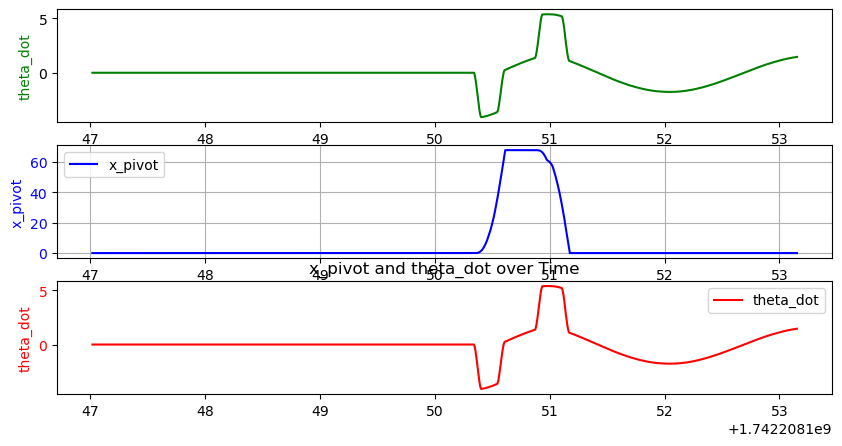

In [15]:
import time
import pygame
from Digital_twin import DigitalTwin
import csv

# Before starting run pip install -r requirements.txt

# Clear the contents of the recording.csv file
with open('recording.csv', mode='w', newline='') as file:
    file.truncate()

digital_twin = DigitalTwin()
        
if __name__=='__main__':
        running = True
        while running:
            
            theta, theta_dot, x_pivot = digital_twin.step()
            digital_twin.render(theta, x_pivot)
            time.sleep(digital_twin.delta_t)

            # Save the theta, theta_dot, x_pivot to plot later
            with open('recording.csv', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([time.time(), theta, theta_dot, x_pivot])
            
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running = False
                elif event.type == pygame.KEYDOWN:
                    if event.key in digital_twin.actions:
                        direction, duration = digital_twin.actions[event.key]
                        digital_twin.perform_action(direction, duration)
                    elif event.key == pygame.K_r:
                            digital_twin = DigitalTwin()  # Restart the system
                            print("System restarted")
                    elif event.key == pygame.K_ESCAPE:
                        running = False # Quit the simulation

        pygame.quit()

# Plot the data
# Load the data from the CSV file
import pandas as pd
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('recording.csv', header=None, names=['time', 'theta', 'theta_dot', 'x_pivot'])

# Create figure and axis
fig, ax = plt.subplots(3,1, figsize=(10, 5))

ax[0].plot(data['time'], data['theta_dot'], label='theta_dot', color='green')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('theta_dot', color='green')
# ax[0].tick_params(axis='y', labelcolor='green')


ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('x_pivot', color='blue')
ax[1].plot(data['time'], data['x_pivot'], label='x_pivot', color='blue')
ax[1].tick_params(axis='y', labelcolor='blue')

# Second y-axis for theta_dot
ax[2].set_ylabel('theta_dot', color='red')
ax[2].plot(data['time'], data['theta_dot'], label='theta_dot', color='red')
ax[2].tick_params(axis='y', labelcolor='red')

# Title and Grid
plt.title('x_pivot and theta_dot over Time')
ax[1].grid(True)

# Legends
ax[1].legend(loc='upper left')
ax[2].legend(loc='upper right')

# Show plot
plt.show()


In [16]:

class DigitalTwin:
    def __init__(self):
        # Initialize Pygame parameters
        self.screen = None

        # Initialize serial communication parameters
        self.ser = None
        self.device_connected = False

###

        self.x_pivot_limit = 100
        self.integral_error = 0.0

###

        # State configuration parameters
        self.steps = 0
        self.theta = 0.     #np.pi-0.01
        self.theta_dot = 0.
        self.theta_double_dot = 0.
        self.x_pivot = 0
        self.delta_t = 0.005  # Example value, adjust as needed in seconds
        self.j_fric = 0.3

        # Model parameters
        self.m = 1         # Mass of the pendulum (kg)
        self.g = 9.8065     # Acceleration due to gravity (m/s^2)
        self.l = 0.8       # Length of the pendulum (m)
        self.c_air = 0.02    # Air friction coefficient
        self.c_c = 0.1      # Coulomb friction coefficient
        self.a_m = 2000     # Motor acceleration force tranfer coefficient
        self.future_motor_accelerations = []
        self.future_motor_positions = []
        self.currentmotor_acceleration = 0.
        self.time = 0.
        
        # Sensor data
        self.sensor_theta = 0
        self.current_sensor_motor_position = 0.
        self.current_action = 0
        
        # Keyboard action mappings
        _action_durations = [200, 150, 100, 50]  # Durations in milliseconds
        _keys_left = [pygame.K_a, pygame.K_s, pygame.K_d, pygame.K_f]
        _keys_right = [pygame.K_SEMICOLON, pygame.K_l, pygame.K_k , pygame.K_j]
        self.actions = {key: ('left', duration) for key, duration in zip(_keys_left, _action_durations)}
        self.actions.update({key: ('right', duration) for key, duration in zip(_keys_right, _action_durations)})
        self.action_map = [
            ('left', 0),  # No action
            ('left', 50), ('left', 100), ('left', 150), ('left', 200),
            ('right', 50), ('right', 100), ('right', 150), ('right', 200)
        ]
        self.recording = False
        self.writer = None
        self.start_time = 0.
        self.df = None
        
        # Initialize a pygame window
        self.initialize_pygame_window()

    def initialize_pygame_window(self):
        # Set up the drawing window
        pygame.init()
        self.screen = pygame.display.set_mode([1000, 800])

    def connect_device(self, port='COM3', baudrate=115200):
        # Establish a serial connection for sensor data
        self.ser = serial.Serial(port=port, baudrate=baudrate, timeout=0, writeTimeout=0)
        self.device_connected = True
        print("Connected to: " + self.ser.portstr)

    def read_data(self):
        line = self.ser.readline()
        line = line.decode("utf-8")
        try:
            if len(line) > 2 and line != '-':
                sensor_data = line.split(",")
                if len(sensor_data[0]) > 0 and len(sensor_data[3]) > 0:
                    self.sensor_theta = int(sensor_data[0])
                    self.current_sensor_motor_position = -int(sensor_data[3])
        except Exception as e:
            print(e)
        if self.recording:
            self.writer.writerow([round(time.time() * 1000)-self.start_time, self.sensor_theta, self.current_sensor_motor_position])

    def process_data(self):
        """
        Lab 2: Use the sensor data retured by the function read_data. 
        The sensor data needs to be represented in the virtual model.
        First the data should be scaled and calibrated,
        Secondly noise should be reduced trough a filtering method.
        Return the processed data such that it can be used in visualization and recording.
        Also, transform the current_sensor_motor_position to be acurate. 
        This means that the encoder value should be scaled to match the displacement in the virtual model.
        """
        self.sensor_theta = 0
        self.current_sensor_motor_position = 0
        
    def start_recording(self, name):
        # If you are working on the bonus assignments then you should also add a columb for actions (and safe those).
        self.recording = True
        self.file = open('{}.csv'.format(name), 'w', newline='')  
        self.writer = csv.writer(self.file)
        self.start_time = round(time.time() * 1000)
        self.writer.writerow(["time", "theta", "x_pivot"])

    def stop_recording(self):
        self.recording = False
        self.file.close()
    
    def load_recording(self, name):
        self.df = pd.read_csv('{}.csv'.format(name))
        print("recording is loaded")
    
    def recorded_step(self,i):
        a = self.df["time"].pop(i)
        b = self.df["theta"].pop(i)
        c = self.df["x_pivot"].pop(i)  
        return a, b, c

    def perform_action(self, direction, duration):
        # Send the command to the device.
        if self.device_connected:
            if direction == 'left':
                d = -duration
            else:
                d = duration
            self.ser.write(str(d).encode())
        if duration > 0:
            self.update_motor_accelerations(direction, duration/1000)

    def update_motor_accelerations(self, direction, duration):
        if direction == 'left':
            direction = -1
        else:
            direction = 1

        """
        Lab 1 & 3 bonus: Model the expected acceleration response of the motor.  
        """
        a_m_1 = 0.05
        a_m_2 = 0.05
        t1 = duration/4
        t2_d = duration/4
        t2 = duration - t2_d
        for t in np.arange(0.0, duration + self.delta_t, self.delta_t):
            if t <= t1:
                c = -4 * direction * a_m_1/(t1 * t1) * t * (t-t1)
            elif t < t2 and t > t1:
                c = 0 
            elif t >= t2:
                c = 4 * direction * a_m_2 /(t2_d * t2_d) * (t-t2) * (t-duration)
            
            self.future_motor_accelerations.append(c)
        
        _velocity = cumulative_trapezoid(self.future_motor_accelerations,initial=0)
        self.future_motor_positions = list(cumulative_trapezoid(_velocity,initial=0))
        
    def get_theta_double_dot(self, theta, theta_dot):
        """
        Lab 1: Model the angular acceleration (theta_double_dot) 
        as a function of theta, theta_dot and the self.currentmotor_acceleration. 
        You should include the following constants as well: c_air, c_c, a_m, l and g. 
        """

        theta_double_dot =  - (1 / self.l ) * self.currentmotor_acceleration * self.a_m * math.cos(theta) \
                            - (self.g / self.l) * np.sin(theta) \
                            - (self.c_air) * theta_dot \
                            - (self.j_fric) * theta_dot
                            # - (self.c_c / self.m * self.l ** 2) * (theta_dot) \
        # theta_double_dot = - self.g / self.l * np.sin(theta) \
        #                     - self.a_m / self.l * self.currentmotor_acceleration \
        #                     - self.c_air / self.l * theta_dot
        # Calculate angular acceleration using the equation of motion
        # theta_double_dot = (-self.g / self.l) * np.sin(theta) \
        #                - (self.c_air / (self.l ** 2)) * theta_dot \
        #                - (self.c_c / (self.l ** 2)) * np.sign(theta_dot) \
        #                + (self.a_m / (self.l ** 2)) * self.currentmotor_acceleration
        return theta_double_dot


    def step(self):
        # Get the predicted motor acceleration for the next step and the shift in x_pivot
        self.check_prediction_lists()
        self.currentmotor_acceleration = self.future_motor_accelerations.pop(0)
        self.x_pivot = self.x_pivot + self.future_motor_positions.pop(0)/3
        
        # Update the system state based on the action and model dynamics
        self.theta_double_dot = self.get_theta_double_dot(self.theta, self.theta_dot)
        self.theta += self.theta_dot * self.delta_t
        self.theta_dot += self.theta_double_dot * self.delta_t
        self.time += self.delta_t
        self.steps += 1
        
        return self.theta, self.theta_dot, self.theta_double_dot, self.x_pivot


    def draw_line_and_circles(self, colour, start_pos, end_pos, line_width=5, circle_radius=9):
        pygame.draw.line(self.screen, colour, start_pos, end_pos, line_width)
        pygame.draw.circle(self.screen, colour, start_pos, circle_radius)
        pygame.draw.circle(self.screen, colour, end_pos, circle_radius)

    def draw_pendulum(self, colour ,x, y, x_pivot):
        self.draw_line_and_circles(colour, [x_pivot+500, 400], [y+x_pivot+500, x+400])
        
    def render(self, theta, x_pivot):
        self.screen.fill((255, 255, 255))
        # Drawing length of the pendulum
        l = 100
        self.draw_pendulum((0,0,0),math.cos(theta)*l,math.sin(theta)*l,x_pivot)
        # Draw black line and circles for horizontal axis
        self.draw_line_and_circles((0, 0, 0), [400, 400], [600, 400])
        pygame.display.flip()

    def check_prediction_lists(self):
        if len(self.future_motor_accelerations) == 0:
            self.future_motor_accelerations = [0]
        if len(self.future_motor_positions) == 0:
            self.future_motor_positions = [0]




In [17]:
import time
import pygame
from Digital_twin import DigitalTwin
import csv

# Before starting run pip install -r requirements.txt

# Clear the contents of the recording.csv file
with open('recording.csv', mode='w', newline='') as file:
    file.truncate()

digital_twin = DigitalTwin()

if __name__ == '__main__':
    running = True
    while running:
        theta, theta_dot, theta_double_dot, x_pivot = digital_twin.step()
        digital_twin.render(theta, x_pivot)
        time.sleep(digital_twin.delta_t)

        # Save the theta, theta_dot, theta_double_dot, x_pivot to plot later
        with open('recording.csv', mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([time.time(), theta, theta_dot, theta_double_dot, x_pivot])
        
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            elif event.type == pygame.KEYDOWN:
                if event.key in digital_twin.actions:
                    direction, duration = digital_twin.actions[event.key]
                    digital_twin.perform_action(direction, duration)
                elif event.key == pygame.K_r:
                    digital_twin = DigitalTwin()  # Restart the system
                    print("System restarted")
                elif event.key == pygame.K_ESCAPE:
                    running = False # Quit the simulation

    pygame.quit()


# Plot the data
# Load the data from the CSV file
import pandas as pd
import matplotlib.pyplot as plt

# Create figure and axis
# Load data
data = pd.read_csv('recording.csv', header=None, names=['time', 'theta', 'theta_dot', 'theta_double_dot', 'x_pivot'])

# Create figure and axis
fig, ax = plt.subplots(3, 1, figsize=(10, 8))

# Plot theta_double_dot in ax[0]
ax[0].plot(data['time'], data['theta_double_dot'], label='theta_double_dot', color='blue')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('theta_double_dot', color='blue')
ax[0].tick_params(axis='y', labelcolor='blue')
ax[0].grid(True)
ax[0].legend(loc='upper left')

# Plot x_pivot in ax[1]
ax[1].plot(data['time'], data['x_pivot'], label='x_pivot', color='green')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('x_pivot', color='green')
ax[1].tick_params(axis='y', labelcolor='green')
ax[1].grid(True)
ax[1].legend(loc='upper left')

# Plot theta_dot in ax[2]
ax[2].plot(data['time'], data['theta_dot'], label='theta_dot', color='red')
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('theta_dot', color='red')
ax[2].tick_params(axis='y', labelcolor='red')
ax[2].grid(True)
ax[2].legend(loc='upper left')

# Title
plt.suptitle('Pendulum Dynamics over Time')

# Show plot
plt.tight_layout()
plt.show()


ValueError: not enough values to unpack (expected 4, got 3)